Import des librairies

In [15]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pythermalcomfort import two_nodes
from SALib.sample import sobol
from SALib.analyze import sobol as analyse_sobol
from SALib.plotting.bar import plot as barplot


In [16]:

current_directory = os.getcwd()

# List all files in the current directory
files = os.listdir(current_directory)

# Iterate through all files
for file in files:
    if file.endswith('.py'):
        # Skip Python files
        continue
    else:
        # Delete non-Python files
        os.remove(os.path.join(current_directory, file))

In [17]:
model = "Gagge's Two-Nodes" # Name of model for plot titles
filename='GAGGE_2NODES' # Eventual filename for exporting all csv outputs
doyouwanttoploteverything = True  # Flag if will to export all data in csv and all plot for each degree step (True if will to plot)

In [18]:
def model4sa(tdb,
                tr,
                v,
                rh,
                met,
                clo,
                standard="ASHRAE", limit_inputs=False, round=False):
    
    pythermal=two_nodes(tdb=tdb,
                        tr=tr,
                        v=v,
                        rh=rh,
                        met=met,
                        clo=clo,
                        standard="ASHRAE", limit_inputs=False, round=False)
    
    pts = 0.25 * pythermal['_set'] - 6.03
    es=1.33
    l=0.195
    tsv_se = es * pts
    tsv_sa = pts/(1+l*pts)
    
    return {"_set": pythermal['_set'],
                    "et":pythermal['et'],
                    "t_core" : pythermal['t_core'],
                    "t_skin" : pythermal['t_skin'],
                    "pmv_gagge" : pythermal['pmv_gagge'],
                    "pmv_set" : pythermal['pmv_set'],
                    'w' : pythermal['w'],
                    'w_max' : pythermal['w_max'],
                    "disc" : pythermal['disc'],
                    "t_sens" : pythermal['t_sens'],
                    'pts' : pts,
                    'tsv_se':tsv_se,
                    'tsv_sa':tsv_sa}

In [19]:
model_output_names="_set"
                    # "et",
                    # "t_core",
                    # "t_skin",
                    # "pmv_gagge",
                    # "pmv_set",
                    # 'w',
                    # 'w_max',
                    # "disc",
                    # "t_sens",
                    # 'pts',
                    # 'tsv_se',
                    # 'tsv_sa'
                    
                    

In [20]:
# Define number of sample for SA, need to be determined after a Si (S1) convergence study
samples=10000
# Define input variable ranges based on possible model inputs
lower_v = 0.01 
upper_v = 2.2
# lower_met = 0.65
# upper_met = 1.26
lower_clo = 0.29
upper_clo = 0.79
lower_tdb = 25.4
upper_tdb = 32.1
lower_tr = 23.1
upper_tr = 31.2
lower_rh = 60
upper_rh = 90

In [21]:
# Define SA problem (SALIB package)
problem = {
    'num_vars': 5, # number of variable inputs
    'names': [ 'tdb','tr','rh','v','clo'], # input names in correct order
    'bounds': [
        [lower_tdb, upper_tdb],
        [lower_tr, upper_tr],
        [lower_rh, upper_rh],
        [lower_v, upper_v],
        [lower_clo, upper_clo]
            ],
    'dist' : ['unif',
              'unif',
              'unif',
              'unif',
              'unif']    
            
        }

In [29]:
# Generate the parameter samples using SALIB RBDfast recommanded method (Latin Hypercube sampling)
sampling = sobol.sample(problem, samples)
# Evaluate model
Y = [model4sa(tdb=params[0],
                    tr=params[1],
                    rh=params[2],
                    v=params[3],
                    met=1.1,
                    clo=params[4],
                    standard="ASHRAE", limit_inputs=False, round=False)[model_output_names] for params in sampling
                    ]

c:\_GIT_HUB_PIMENTLAB\simurex-atelier-sa\.venv\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [23]:
pd.DataFrame(Y)

,0
0,26.000928
1,28.484696
2,24.994898
3,25.840653
4,23.657435
...,...
119995,21.711283
119996,20.447202
119997,20.913121
119998,24.195794


In [31]:
len(sampling)

120000

In [25]:
Si = analyse_sobol.analyze(problem,  np.asarray(Y), calc_second_order=True,print_to_console=False)
total, first, second = Si.to_df()

           ST   ST_conf
tdb  0.423534  0.012592
tr   0.089979  0.002792
rh   0.059170  0.002073
v    0.220910  0.007030
clo  0.228119  0.006419


<Axes: >

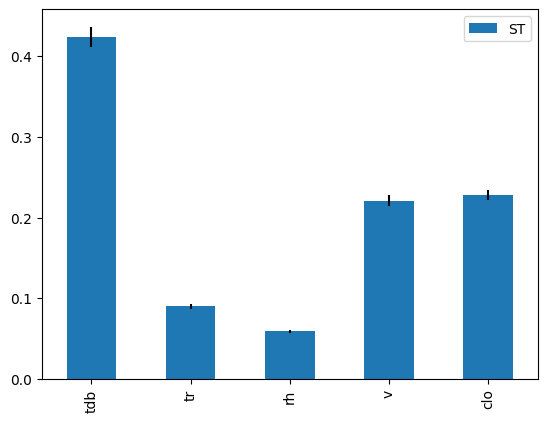

In [26]:
print(total)
barplot(total)


In [32]:
print(Si)

{'S1': array([0.41037681, 0.08501515, 0.045003  , 0.21244695, 0.22415089]), 'S1_conf': array([0.01720659, 0.0082565 , 0.00738794, 0.01299276, 0.01152424]), 'ST': array([0.42353376, 0.08997914, 0.05917028, 0.22091038, 0.2281188 ]), 'ST_conf': array([0.01259218, 0.00279184, 0.00207268, 0.00702997, 0.00641864]), 'S2': array([[       nan, 0.00023523, 0.01098524, 0.00108733, 0.00095796],
       [       nan,        nan, 0.00069098, 0.00425427, 0.00074612],
       [       nan,        nan,        nan, 0.00157979, 0.00125177],
       [       nan,        nan,        nan,        nan, 0.00184824],
       [       nan,        nan,        nan,        nan,        nan]]), 'S2_conf': array([[       nan, 0.0248038 , 0.02511   , 0.02789498, 0.02796335],
       [       nan,        nan, 0.01156237, 0.01218378, 0.01301718],
       [       nan,        nan,        nan, 0.01237815, 0.01147331],
       [       nan,        nan,        nan,        nan, 0.02020272],
       [       nan,        nan,        nan,      

           S1   S1_conf
tdb  0.410377  0.017207
tr   0.085015  0.008256
rh   0.045003  0.007388
v    0.212447  0.012993
clo  0.224151  0.011524


<Axes: >

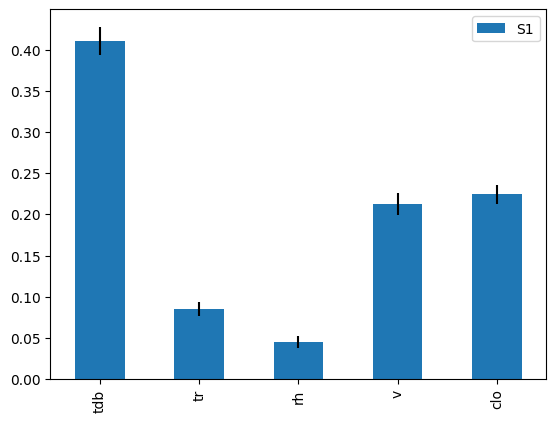

In [27]:
print(first)
barplot(first)

                  S2   S2_conf
(tdb, tr)   0.000235  0.024804
(tdb, rh)   0.010985  0.025110
(tdb, v)    0.001087  0.027895
(tdb, clo)  0.000958  0.027963
(tr, rh)    0.000691  0.011562
(tr, v)     0.004254  0.012184
(tr, clo)   0.000746  0.013017
(rh, v)     0.001580  0.012378
(rh, clo)   0.001252  0.011473
(v, clo)    0.001848  0.020203


<Axes: >

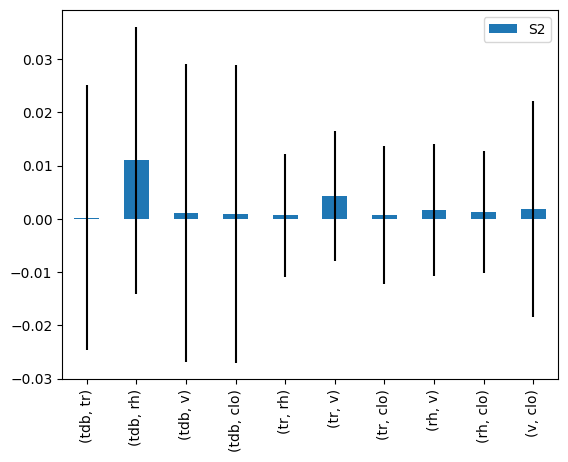

In [28]:
print(second)
barplot(second)